# POKEMON Deep Convolutional Generative Adversarial Network

# Libraries Imports

In [10]:
import tensorflow as tf
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import tqdm
import PIL
from tensorflow.keras import layers
import time
import cv2

from IPython import display

# ETL (Load and prepare the dataset)

## Loading dataset + preprocessing function

In [15]:
def gather_dataset(path):
    image_list = os.listdir(path)
    ds = []
    for img in tqdm.tqdm(image_list, 'Images'):
        img_path = os.path.join(path,img)
        image_array = imageio.imread(img_path)
        image_array = cv2.normalize(image_array, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
        ds.append(image_array)
    print('DATASET COMPILED!')
    return ds

In [64]:
pokemon_images_path = r'J:\Keravnos_X-files\CS\datasets\pokemon\archive\pokemon\pokemon'
# pokemon_images_path = r'J:\Keravnos_X-files\CS\datasets\pokemon\archive\pokemon_jpg\pokemon_jpg'

pokemon_train_images = gather_dataset(pokemon_images_path)
pokemon_train_images = np.asarray(pokemon_train_images, dtype=object)
dataset_shape = pokemon_train_images.shape
dataset_shape

Images: 100%|███████████████████████████████████████████████████████████████████████| 819/819 [00:06<00:00, 128.87it/s]

DATASET COMPILED!


(819, 256, 256, 4)

## ****OPTIONAL SAVE/LOAD*** (use to cut through ETL even though its quite fast anyway)

In [77]:
np.save('C:/Users/Keravnos/Downloads/POKEGAN/pokemon_train_images.npy', pokemon_train_images)

In [ ]:
pokemon_train_images = np.load('pokemon_train_images.npy', allow_pickle=True)


## Additional dataset transformations

- Typecasting
- Pass to tensor slices
- Suffle and prefetch dataset according to batch size

In [81]:
# BUFFER_SIZE = 60000
BUFFER_SIZE = dataset_shape[0]*2
BATCH_SIZE = 8
EPOCHS = 200
noise_dim = 100
num_examples_to_generate = 16

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [65]:
pokemon_train_images = pokemon_train_images.reshape(dataset_shape).astype('float32')
pokemon_train_images = tf.data.Dataset.from_tensor_slices((pokemon_train_images))
pokemon_train_images = pokemon_train_images.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(1)

# CREATE THE **G** AND **D**

### The Generator

The generator uses `tf.keras.layers.Conv2DTranspose` (upsampling) layers to produce an image from a seed (random noise). Start with a `Dense` layer that takes this seed as input, then upsample several times until you reach the desired image size of 28x28x1. Notice the `tf.keras.layers.LeakyReLU` activation for each layer, except the output layer which uses tanh.

In [79]:
def make_generator_model():
    model = tf.keras.Sequential()

    model.add(layers.Dense(64*64*256, use_bias=False, input_shape=(noise_dim,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((64, 64, 256)))
    assert model.output_shape == (None, 64, 64, 256)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 64, 64, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 128, 128, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(4, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    print(model.output_shape)
    assert model.output_shape == (None, 256, 256, 4)

    return model

Use the (as yet untrained) generator to create an image.

(None, 256, 256, 4)


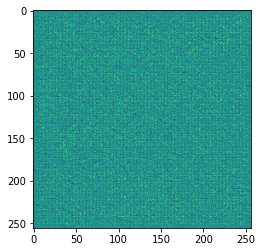

In [82]:
generator = make_generator_model()

noise = tf.random.normal([1, noise_dim])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :,0])

### The Discriminator

The discriminator is a CNN-based image classifier.

In [73]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[256, 256, 4]))
    model.add(layers.GaussianNoise(0.2))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.GaussianNoise(0.2))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

Use the (as yet untrained) discriminator to classify the generated images as real or fake. The model will be trained to output positive values for real images, and negative values for fake images.

In [83]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[4.974389e-05]], shape=(1, 1), dtype=float32)


## Define the loss and optimizers

Define loss functions and optimizers for both models.


In [29]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

### Discriminator loss

This method quantifies how well the discriminator is able to distinguish real images from fakes. It compares the discriminator's predictions on real images to an array of 1s, and the discriminator's predictions on fake (generated) images to an array of 0s.

In [30]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

### Generator loss
The generator's loss quantifies how well it was able to trick the discriminator. Intuitively, if the generator is performing well, the discriminator will classify the fake images as real (or 1). Here, compare the discriminators decisions on the generated images to an array of 1s.

In [31]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

The discriminator and the generator optimizers are different since you will train two networks separately.

In [32]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

### Save checkpoints
This notebook also demonstrates how to save and restore models, which can be helpful in case a long running training task is interrupted.

In [33]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

# TRAINING

## Define the training loop


The training loop begins with generator receiving a random seed as input. That seed is used to produce an image. The discriminator is then used to classify real images (drawn from the training set) and fakes images (produced by the generator). The loss is calculated for each of these models, and the gradients are used to update the generator and discriminator.

In [85]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
 
        # data augments
        #       images = tf.image.stateless_random_hue(images, 0.2, (2, 3))
        #       images = tf.image.stateless_random_flip_left_right(images, (2, 3))

        # TRY THIS
        image = tf.image.random_flip_left_right(images)
        image = tf.image.random_brightness(images, max_delta = 0.1)
        image = tf.image.random_contrast(images, lower = 0.9, upper = 1.1)
    
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [86]:
def train(dataset, epochs):
  for epoch in tqdm.tqdm(range(epochs),'Epochs'):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

### **Generate and save images**


In [87]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(8, 8))

  for i in range(predictions.shape[0]):
      plt.subplot(8, 8, i+1)
      plt.imshow(predictions[i, :, :, 0])
      plt.axis('off')

  plt.savefig('./output_imgs/image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

## Train the model
Call the `train()` method defined above to train the generator and discriminator simultaneously. Note, training GANs can be tricky. It's important that the generator and discriminator do not overpower each other (e.g., that they train at a similar rate).

At the beginning of the training, the generated images look like random noise. As training progresses, the generated digits will look increasingly real. After about 50 epochs, they resemble MNIST digits. This may take about one minute / epoch with the default settings on Colab.

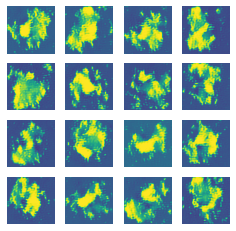

Epochs:  82%|███████████████████████████████████████████████████████████             | 164/200 [32:19<07:05, 11.83s/it]


UnknownError: Failed to WriteFile: ./training_checkpoints\ckpt-31_temp/part-00000-of-00001.data-00000-of-00001.tempstate6658003847783481091 : There is not enough space on the disk.
; operation in progress [Op:SaveV2]

In [88]:
train(pokemon_train_images, EPOCHS)

Restore the latest checkpoint.

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

## Create a GIF


In [51]:
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

In [ ]:
display_image(EPOCHS)

Use `imageio` to create an animated gif using the images saved during training.

In [ ]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

In [ ]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)